--- Kiểm tra và cấu hình GPU ---
✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.
------------------------------

🧹 Đang cố gắng dọn dẹp bộ nhớ...
✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.

✅ Đã tìm thấy các file .npz trong 'E:/tmp_sliding_chunks' và scaler trong 'E:/tmp_scalers'. Đang tải...
✅ Đã tải các scaler từ 'E:/tmp_scalers'.
✅ Đã tìm thấy 109 file .npz. Đang tải dữ liệu...

⏳ Đang đếm tổng số mẫu từ các file NPZ...
✅ Tổng số mẫu được tải: 905484

📊 Tổng số mẫu: 905484
📚 Số samples cho tập Train: 543232 (khoảng 4244 batches)
🧪 Số samples cho tập Validation: 180992 (khoảng 1414 batches)
🎯 Số samples cho tập Test: 181098 (số lượng thực tế sẽ là 180992 nếu batching đến hết hoặc nhỏ hơn nếu batch cuối cùng)
✅ Hoàn thành chia tập dữ liệu.

🚀 Bắt đầu huấn luyện mô hình LSTM...
📈 Số lượng đặc trưng (num_features) được tự động phát hiện: 11
Model: "sequential"
_________________________________________________________________
 Layer (type)                Ou

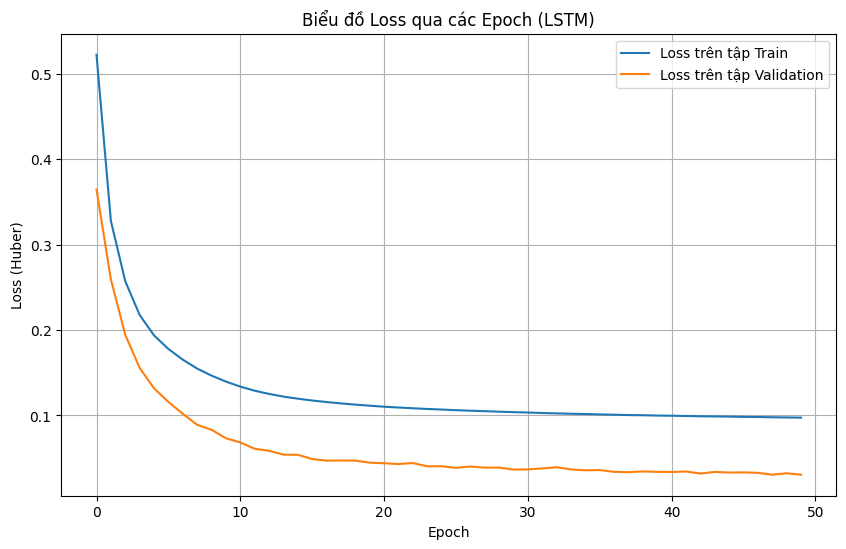

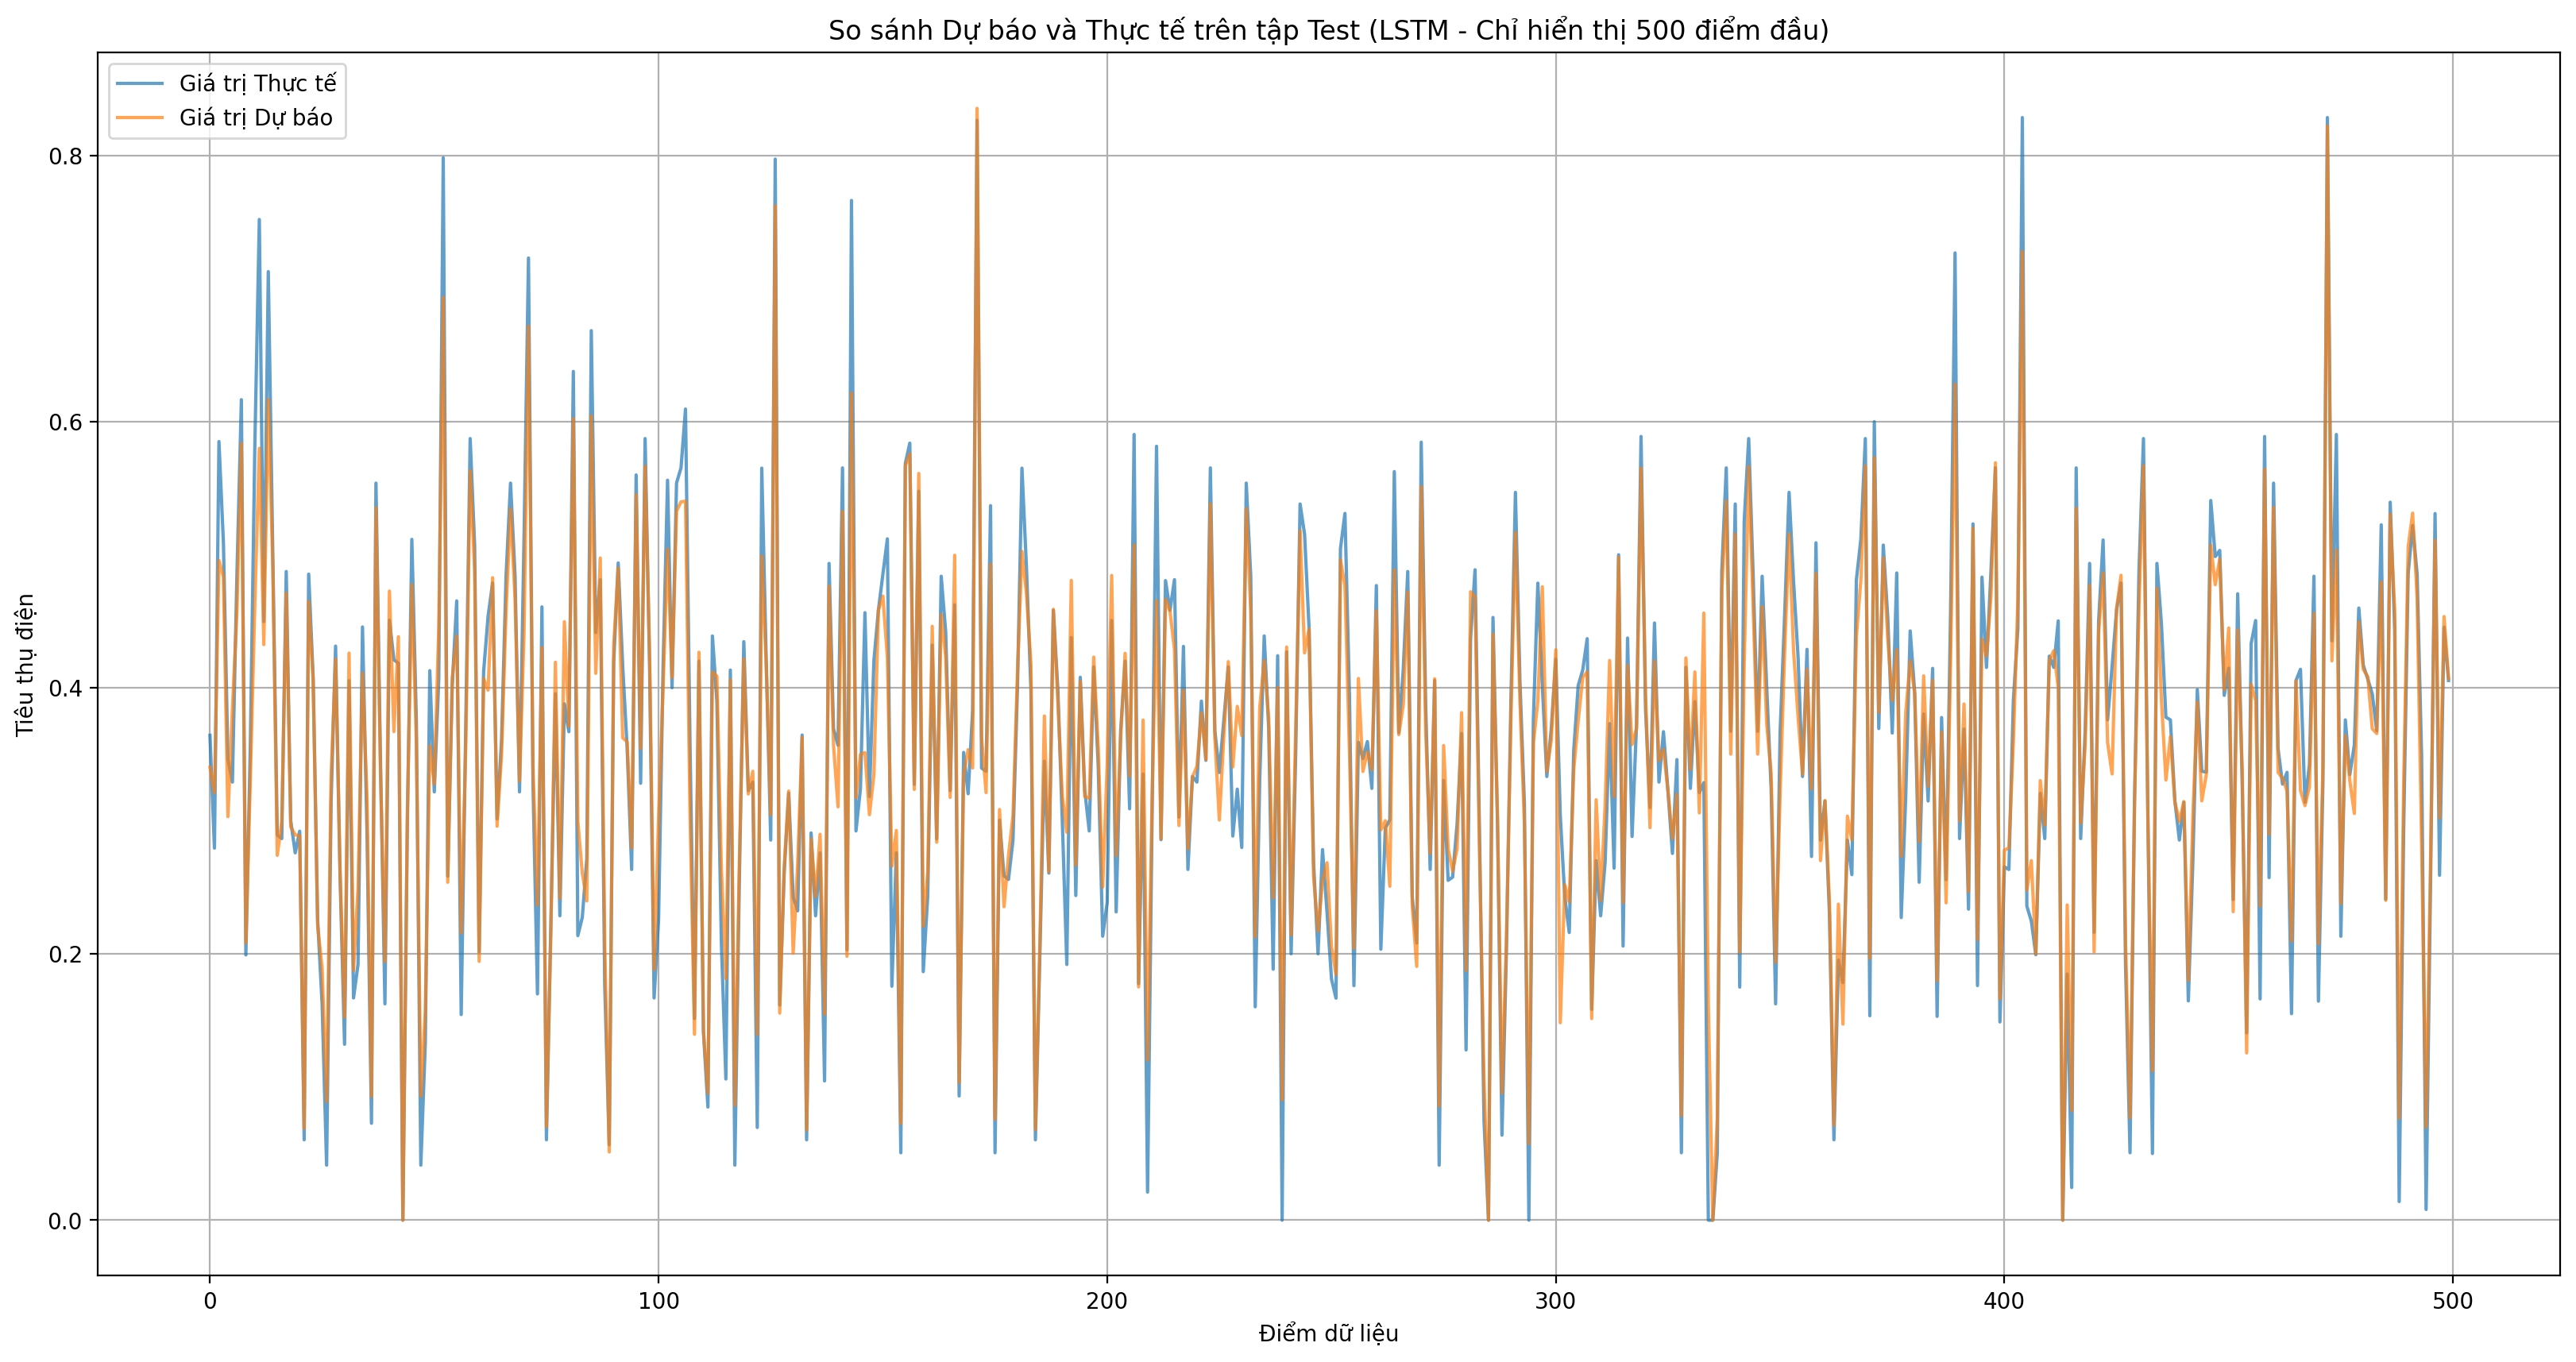

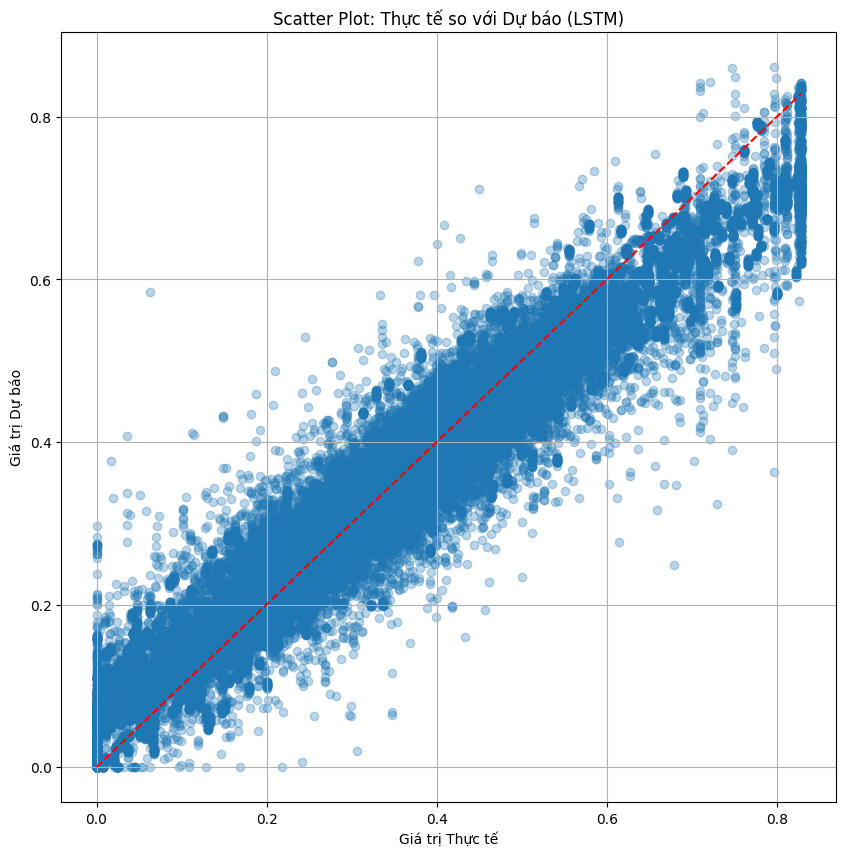


Tổng thời gian chạy toàn bộ pipeline (LSTM): 9642.16 giây


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gc
import joblib

print("--- Kiểm tra và cấu hình GPU ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động. Có thể GPU đã được khởi tạo.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")
print("------------------------------")


FILE_PATH = 'C:/CODE/Python/11gb_data.csv' 


TEMP_CHUNKS_DIR_COMMON = 'E:/tmp_sliding_chunks' 
SCALER_DIR_COMMON = 'E:/tmp_scalers'             


LSTM_CHECKPOINT_FILE = 'best_model_weights_lstm.weights.h5'
LSTM_CHECKPOINT_PATH = os.path.join(SCALER_DIR_COMMON, LSTM_CHECKPOINT_FILE)


os.makedirs(TEMP_CHUNKS_DIR_COMMON, exist_ok=True)
os.makedirs(SCALER_DIR_COMMON, exist_ok=True)

# --- CÁC HẰNG SỐ CỦA MÔ HÌNH VÀ DATA ---
WINDOW_SIZE = 48
HORIZON = 24
STRIDE = 6

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000

# --- CÁC HÀM TIỀN XỬ LÝ DỮ LIỆU ---
# Các hàm này giữ nguyên logic như của Informer
def read_and_resample_chunks(csv_path, chunk_size=100_000):
    all_resampled_data = []
    print(f"📦 Đang bắt đầu quá trình đọc và resample chunk từ file CSV '{csv_path}'...")
    
    custom_dtypes = {
        'Value': np.float32, 
      
    }
    
    try:
        chunks = pd.read_csv(
            csv_path, 
            parse_dates=['Timestamp'], 
            chunksize=chunk_size,
            low_memory=True,
            dtype=custom_dtypes 
        )
    except Exception as e:
        print(f"❌ Lỗi khi đọc file CSV: {e}")
        print("Gợi ý: Kiểm tra lại tên các cột trong 'custom_dtypes' có khớp với file CSV không.")
        print("Hoặc thử bỏ 'dtype=custom_dtypes' nếu bạn không chắc chắn, nhưng nó có thể dùng nhiều RAM hơn.")
        raise 

    for i, chunk in enumerate(chunks):
        if chunk.empty:
            print(f"Chunk {i} rỗng, bỏ qua.")
            continue
        print(f"⏳ Đang xử lý Chunk {i} ({len(chunk)} dòng)...")
        
        chunk = chunk.set_index('Timestamp').sort_index()

        chunk['hour_sin'] = np.sin(2 * np.pi * chunk.index.hour / 24)
        chunk['hour_cos'] = np.cos(2 * np.pi * chunk.index.hour / 24)
        chunk['dayofweek_sin'] = np.sin(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofweek_cos'] = np.cos(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofyear_sin'] = np.sin(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['dayofyear_cos'] = np.cos(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['is_weekend'] = (chunk.index.dayofweek >= 5).astype(int)

        if 'Anomaly_Label' in chunk.columns:
            chunk = chunk.drop(columns=['Anomaly_Label'])
        
        if 'Meter_ID' in chunk.columns:
            chunk = chunk.drop(columns=['Meter_ID'])
        if 'Meter_ID_Numeric' in chunk.columns:
            chunk = chunk.drop(columns=['Meter_ID_Numeric'])

        numeric_chunk = chunk.select_dtypes(include=[np.number])

        numeric_chunk = numeric_chunk.interpolate(method='time', limit_direction='both')
        resampled_chunk = numeric_chunk.resample('1h').mean()
        resampled_chunk = resampled_chunk.ffill().bfill()
        
        if resampled_chunk.isnull().any().any():
            print(f"Cảnh báo: Chunk {i} vẫn còn giá trị NaN sau khi resample. Đang điền bằng trung bình cột.")
            resampled_chunk = resampled_chunk.fillna(resampled_chunk.mean())

        target_column_name = resampled_chunk.columns[0]
        Q1 = resampled_chunk[target_column_name].quantile(0.01)
        Q99 = resampled_chunk[target_column_name].quantile(0.99)
        resampled_chunk[target_column_name] = np.clip(resampled_chunk[target_column_name], Q1, Q99)
        
        for lag in [1, 24, 24*7]:
            resampled_chunk[f'{target_column_name}_lag_{lag}h'] = resampled_chunk[target_column_name].shift(lag)

        resampled_chunk = resampled_chunk.dropna()

        if not resampled_chunk.empty:
            all_resampled_data.append(resampled_chunk)
        print(f"✅ Hoàn thành xử lý Chunk {i}.")
        gc.collect()

    if not all_resampled_data:
        raise ValueError("Không có dữ liệu hợp lệ nào sau khi xử lý tất cả các chunk.")

    full_resampled_df = pd.concat(all_resampled_data)
    print(f"✅ Đã tổng hợp tất cả dữ liệu resample. Tổng số dòng: {len(full_resampled_df)}")
    gc.collect()
    return full_resampled_df

def sliding_save_chunks(data, input_seq_len, output_seq_len, stride, chunk_size, save_dir):
    total_len = input_seq_len + output_seq_len
    
    num_samples = data.shape[0] - total_len + 1 
    num_full_chunks = num_samples // chunk_size
    
    print(f"📊 Tổng số mẫu có thể tạo: {num_samples}")
    print(f"📦 Sẽ tạo khoảng {num_full_chunks + (1 if num_samples % chunk_size != 0 else 0)} file .npz.")

    current_idx = 0
    chunk_file_idx = 0

    while current_idx < num_samples:
        start_chunk_idx = current_idx
        end_chunk_idx = min(current_idx + chunk_size, num_samples)
        
        X_chunk_list = []
        y_chunk_list = []

        for j in range(start_chunk_idx, end_chunk_idx, stride):
            if j + total_len <= data.shape[0]:
                X_sample = data[j : j + input_seq_len]
                y_sample = data[j + input_seq_len : j + total_len, 0]
                X_chunk_list.append(X_sample)
                y_chunk_list.append(y_sample)
            else:
                break

        if X_chunk_list:
            X_chunk_arr = np.array(X_chunk_list, dtype=np.float32)
            y_chunk_arr = np.array(y_chunk_list, dtype=np.float32)
            
            save_path = f"{save_dir}/chunk_{chunk_file_idx}.npz"
            np.savez(save_path, X=X_chunk_arr, y=y_chunk_arr)
            print(f"   💾 Đã lưu {X_chunk_arr.shape[0]} mẫu vào '{save_path}'")
            chunk_file_idx += 1
        
        current_idx = end_chunk_idx

        del X_chunk_list, y_chunk_list, X_chunk_arr, y_chunk_arr
        gc.collect()

def load_npz_dataset(filepaths, batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, shuffle=True):
    def _load_npz_data_and_create_dataset(filepath_tensor):
        filepath_str = filepath_tensor.numpy().decode('utf-8')
        data = np.load(filepath_str)
        X = data['X']
        y = data['y']
        return tf.data.Dataset.from_tensor_slices((X, y))

    files_ds = tf.data.Dataset.from_tensor_slices(filepaths)

    dataset = files_ds.interleave(
        lambda filepath: tf.py_function(
            func=_load_npz_data_and_create_dataset,
            inp=[filepath],
            Tout=tf.data.DatasetSpec(
                element_spec=(
                    tf.TensorSpec(shape=(WINDOW_SIZE, None), dtype=tf.float32), 
                    tf.TensorSpec(shape=(HORIZON,), dtype=tf.float32)          
                )
            )
        ),
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size) 
    
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# --- ĐỊNH NGHĨA MÔ HÌNH LSTM ---
def create_lstm_model(input_shape, output_seq_len, d_model, num_layers, dropout_rate=0.3):
    model = Sequential()
    
    if num_layers == 1:
        model.add(LSTM(d_model, input_shape=input_shape, kernel_regularizer=l2(1e-3)))
    else:
        model.add(LSTM(d_model, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(1e-3)))
    
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for i in range(num_layers - 1):
        if i == num_layers - 2:
            model.add(LSTM(d_model, kernel_regularizer=l2(1e-3)))
        else:
            model.add(LSTM(d_model, return_sequences=True, kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
            
    model.add(Dense(output_seq_len))
    
    return model

# --- KHỐI THỰC THI CHÍNH ---
if __name__ == '__main__':
    start_time_full_process = time.time()
    
    print("\n🧹 Đang cố gắng dọn dẹp bộ nhớ...")
    tf.keras.backend.clear_session() 
    gc.collect() 
    print("✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.")

    # Kiểm tra sự tồn tại của file NPZ và scaler ở THƯ MỤC CHUNG
    existing_npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz'))
    existing_scaler_files = glob.glob(os.path.join(SCALER_DIR_COMMON, '*.pkl'))

    # Nếu KHÔNG CÓ file NPZ HOẶC KHÔNG CÓ file scaler trong thư mục chung, thì chạy tiền xử lý.
    if not existing_npz_files or not existing_scaler_files:
        print("\n⚠️ Không tìm thấy các file NPZ HOẶC Scaler trong thư mục chung.")
        print("⏳ Đang tiến hành tiền xử lý dữ liệu và tạo file. Quá trình này có thể tốn nhiều thời gian...")
        print("💡 Lưu ý: Nếu bạn muốn LSTM dùng chung data của Informer, hãy đảm bảo Informer đã chạy và tạo ra các file ở các đường dẫn đã cấu hình.")
        
        resampled_df = read_and_resample_chunks(FILE_PATH) 
        
        target_column_name = resampled_df.columns[0]

        selected_features = [
            target_column_name,
            f'{target_column_name}_lag_1h',
            f'{target_column_name}_lag_24h',
            f'{target_column_name}_lag_168h', 
            'hour_sin',
            'hour_cos',
            'dayofweek_sin',
            'dayofweek_cos',
            'dayofyear_sin', 
            'dayofyear_cos', 
            'is_weekend',
        ]

        existing_selected_features = [col for col in selected_features if col in resampled_df.columns]
        if 'Temperature' not in resampled_df.columns and 'Temperature' in selected_features:
            print("⚠️ Cảnh báo: Cột 'Temperature' không tồn tại trong dữ liệu sau resample và sẽ bị bỏ qua.")

        data_for_scaling = resampled_df[existing_selected_features].values
        print(f"📊 Dữ liệu sau tiền xử lý và chọn đặc trưng: shape {data_for_scaling.shape}")

        print("💡 Đang fit và transform scaler toàn cục...")
        target_scaler = StandardScaler()
        feature_scaler = StandardScaler()

        target_scaled = target_scaler.fit_transform(data_for_scaling[:, 0].reshape(-1, 1))
        features_scaled = feature_scaler.fit_transform(data_for_scaling[:, 1:])

        data_scaled = np.concatenate((target_scaled, features_scaled), axis=1)
        print("✅ Hoàn thành chuẩn hóa dữ liệu.")
        
        # Lưu scaler vào thư mục chung của Informer
        joblib.dump(target_scaler, os.path.join(SCALER_DIR_COMMON, 'target_scaler.pkl'))
        joblib.dump(feature_scaler, os.path.join(SCALER_DIR_COMMON, 'feature_scaler.pkl'))
        print(f"✅ Đã lưu các scaler vào '{SCALER_DIR_COMMON}'.")

        print(f"\n💾 Đang tạo và lưu sliding windows vào thư mục: {TEMP_CHUNKS_DIR_COMMON}...")
        SLIDING_CHUNK_SIZE = 50_000 
        sliding_save_chunks(data_scaled, WINDOW_SIZE, HORIZON, stride=STRIDE, 
                            chunk_size=SLIDING_CHUNK_SIZE, save_dir=TEMP_CHUNKS_DIR_COMMON) 
        print(f"✅ Hoàn thành tạo và lưu sliding windows vào '{TEMP_CHUNKS_DIR_COMMON}'.")
        
        del resampled_df, data_for_scaling, target_scaled, features_scaled, data_scaled
        gc.collect()

    else:
        print(f"\n✅ Đã tìm thấy các file .npz trong '{TEMP_CHUNKS_DIR_COMMON}' và scaler trong '{SCALER_DIR_COMMON}'. Đang tải...")
        try:
            # TẢI SCALER TỪ THƯ MỤC CHUNG
            target_scaler = joblib.load(os.path.join(SCALER_DIR_COMMON, 'target_scaler.pkl')) #
            feature_scaler = joblib.load(os.path.join(SCALER_DIR_COMMON, 'feature_scaler.pkl')) #
            print(f"✅ Đã tải các scaler từ '{SCALER_DIR_COMMON}'.")
        except Exception as e:
            print(f"❌ Lỗi khi tải scaler: {e}. Vui lòng kiểm tra '{SCALER_DIR_COMMON}' hoặc chạy lại tiền xử lý.")
            exit()

    # Sử dụng các file NPZ từ thư mục chung
    npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz')) #
    if not npz_files:
        print(f"❌ Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR_COMMON}'. Vui lòng kiểm tra đường dẫn hoặc chạy lại tiền xử lý.")
        exit()

    print(f"✅ Đã tìm thấy {len(npz_files)} file .npz. Đang tải dữ liệu...")
    
    sample_data = np.load(npz_files[0])
    sample_X_shape = sample_data['X'].shape
    num_features_in_npz = sample_X_shape[-1]
    del sample_data, sample_X_shape 

    full_dataset_from_npz = load_npz_dataset(npz_files, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, 
                                            shuffle=True)
    
    print("\n⏳ Đang đếm tổng số mẫu từ các file NPZ...")
    total_samples = 0
    for filepath in npz_files:
        data = np.load(filepath)
        total_samples += data['X'].shape[0]
        data.close()
    print(f"✅ Tổng số mẫu được tải: {total_samples}")
    
    train_size = int(0.6 * total_samples)
    val_size = int(0.2 * total_samples)
    test_size = total_samples - train_size - val_size

    train_batches = train_size // BATCH_SIZE
    val_batches = val_size // BATCH_SIZE
    test_batches = test_size // BATCH_SIZE

    train_dataset = full_dataset_from_npz.take(train_batches)
    val_dataset = full_dataset_from_npz.skip(train_batches).take(val_batches)
    test_dataset = full_dataset_from_npz.skip(train_batches + val_batches)

    print(f"\n📊 Tổng số mẫu: {total_samples}")
    print(f"📚 Số samples cho tập Train: {train_batches * BATCH_SIZE} (khoảng {train_batches} batches)")
    print(f"🧪 Số samples cho tập Validation: {val_batches * BATCH_SIZE} (khoảng {val_batches} batches)")
    print(f"🎯 Số samples cho tập Test: {test_size} (số lượng thực tế sẽ là {test_batches * BATCH_SIZE} nếu batching đến hết hoặc nhỏ hơn nếu batch cuối cùng)")
    print("✅ Hoàn thành chia tập dữ liệu.")

    print("\n🚀 Bắt đầu huấn luyện mô hình LSTM...")
    start_train = time.time()

    num_features = num_features_in_npz
    print(f"📈 Số lượng đặc trưng (num_features) được tự động phát hiện: {num_features}")

    model = create_lstm_model(
        input_shape=(WINDOW_SIZE, num_features),
        output_seq_len=HORIZON,
        d_model=64, 
        num_layers=2, 
        dropout_rate=0.3
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.Huber(), 
        metrics=['mae']
    )
    model.summary() 

    # LƯU TRỌNG SỐ MÔ HÌNH LSTM VỚI TÊN VÀ ĐƯỜNG DẪN RIÊNG BIỆT
    checkpoint_filepath = LSTM_CHECKPOINT_PATH #
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7),
        ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )

    print(f"✅ Huấn luyện hoàn tất sau {time.time() - start_train:.2f} giây")

    try:
        model.load_weights(checkpoint_filepath)
        print(f"✅ Đã tải lại trọng số tốt nhất cho LSTM từ '{checkpoint_filepath}'")
    except Exception as e:
        print(f"⚠️ Không tìm thấy trọng số tốt nhất cho LSTM để tải lại hoặc có lỗi: {e}")
        print("Mô hình LSTM sẽ tiếp tục với trọng số cuối cùng của quá trình huấn luyện.")

    print("\n📈 Đang dự báo trên tập test (LSTM)...")
    start_test = time.time()
    
    y_true_list = []
    y_pred_list = []

    for X_batch, y_batch in test_dataset:
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_true_list.append(y_batch.numpy())
        y_pred_list.append(y_pred_batch)

    y_true_all_scaled = np.concatenate(y_true_list, axis=0)
    y_pred_all_scaled = np.concatenate(y_pred_list, axis=0)

    print(f"✅ Dự báo hoàn tất sau {time.time() - start_test:.2f} giây")

    true_scaled_first_step = y_true_all_scaled[:, 0].reshape(-1, 1)
    predicted_scaled_first_step = y_pred_all_scaled[:, 0].reshape(-1, 1)

    # Đảm bảo bạn tải đúng scaler của Informer để đảo ngược chuẩn hóa
    true = target_scaler.inverse_transform(true_scaled_first_step).flatten()
    predicted = target_scaler.inverse_transform(predicted_scaled_first_step).flatten()

    predicted[predicted < 0] = 0
    true[true < 0] = 0

    def smape(y_true, y_pred):
        numerator = np.abs(y_pred - y_true)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-8
        return 100 * np.mean(numerator / denominator)

    print("\n📊 Evaluation on Test Set (LSTM):")
    print(f"MAE  = {mean_absolute_error(true, predicted):.4f}")
    print(f"MSE  = {mean_squared_error(true, predicted):.4f}")
    print(f"RMSE = {np.sqrt(mean_squared_error(true, predicted)):.4f}")

    epsilon = 1e-8
    mape = np.mean(np.abs((true - predicted) / (true + epsilon))) * 100
    print(f"MAPE = {mape:.2f}%")
    print(f"sMAPE= {smape(true, predicted):.2f}%")

    # --- BIỂU ĐỒ ---
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss trên tập Train')
    plt.plot(history.history['val_loss'], label='Loss trên tập Validation')
    plt.title('Biểu đồ Loss qua các Epoch (LSTM)') 
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Huber)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 10), dpi=200)
    sample_size = 500
    plot_true = true[:sample_size] if len(true) >= sample_size else true
    plot_predicted = predicted[:sample_size] if len(predicted) >= sample_size else predicted

    plt.plot(plot_true, label='Giá trị Thực tế', alpha=0.7)
    plt.plot(plot_predicted, label='Giá trị Dự báo', alpha=0.7)
    plt.legend()
    plt.title(f'So sánh Dự báo và Thực tế trên tập Test (LSTM - Chỉ hiển thị {len(plot_true)} điểm đầu)')
    plt.xlabel('Điểm dữ liệu')
    plt.ylabel('Tiêu thụ điện')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.scatter(true, predicted, alpha=0.3)
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
    plt.xlabel('Giá trị Thực tế')
    plt.ylabel('Giá trị Dự báo')
    plt.title('Scatter Plot: Thực tế so với Dự báo (LSTM)') 
    plt.grid(True)
    plt.show()

    print(f"\nTổng thời gian chạy toàn bộ pipeline (LSTM): {time.time() - start_time_full_process:.2f} giây")

In [ ]:
import numpy as np
import tensorflow as tf
import os
import glob
import joblib 

# --- Kiểm tra và cấu hình GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động. Có thể GPU đã được khởi tạo.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")

# --- HẰNG SỐ VÀ ĐƯỜNG DẪN ---
TEMP_CHUNKS_DIR_COMMON = 'E:/tmp_sliding_chunks' 
SCALER_DIR_COMMON = 'E:/tmp_scalers'

# Cập nhật cho LSTM
LSTM_CHECKPOINT_FILE = 'best_model_weights_lstm.weights.h5'
LSTM_CHECKPOINT_PATH = os.path.join(SCALER_DIR_COMMON, LSTM_CHECKPOINT_FILE)

LSTM_FULL_MODEL_SAVE_FILE = 'lstm_full_model.h5'
LSTM_FULL_MODEL_SAVE_PATH = os.path.join(SCALER_DIR_COMMON, LSTM_FULL_MODEL_SAVE_FILE)

WINDOW_SIZE = 48
HORIZON = 24

# --- ĐỊNH NGHĨA MÔ HÌNH LSTM ENCODER-DECODER (SỬ DỤNG HÀM FUNCTIONAL API) ---
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed
from tensorflow.keras.models import Model # Cần import Model ở đây

def create_lstm_encoder_decoder_model(
    input_seq_len,
    output_seq_len,
    num_encoder_features,
    num_decoder_features=1,
    lstm_units=128,
    l2_reg=1e-3
):
    encoder_inputs = Input(shape=(input_seq_len, num_encoder_features), name='encoder_inputs')
    
    # LSTM Encoder trả về trạng thái cuối cùng
    encoder_lstm = LSTM(lstm_units, return_state=True, kernel_regularizer=l2(l2_reg))
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) # Lấy cả state_h và state_c
    encoder_states = [state_h, state_c] # Trạng thái của LSTM là một list [h, c]
    
    decoder_inputs = Input(shape=(output_seq_len, num_decoder_features), name='decoder_inputs')
    
    # Decoder LSTM nhận initial_state từ encoder và trả về sequence
    decoder_lstm = LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg))
    # Truyền trạng thái của encoder vào decoder
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    
    # TimeDistributed Dense layer để dự đoán mỗi bước trong sequence
    output_predictions = TimeDistributed(Dense(1, activation='linear'))(decoder_outputs)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output_predictions)
    return model

# --- PHẦN CHÍNH CỦA SCRIPT ĐỂ TẢI TRỌNG SỐ VÀ LƯU MÔ HÌNH ---

if __name__ == '__main__':
    tf.keras.backend.clear_session() 

    print("\n--- Bắt đầu quá trình xuất mô hình LSTM Encoder-Decoder ---")

    # 1. Xác định num_encoder_features
    npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz')) 
    if not npz_files:
        print(f"❌ Lỗi: Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR_COMMON}'.")
        print("Vui lòng đảm bảo các file NPZ đã được tạo bởi quá trình tiền xử lý/huấn luyện LSTM.")
        exit()

    sample_data = np.load(npz_files[0])
    num_encoder_features = sample_data['X'].shape[-1]
    sample_data.close() 
    print(f"📈 Số lượng đặc trưng đầu vào (num_encoder_features) được xác định: {num_encoder_features}")

    # 2. Khởi tạo mô hình LSTMEncoderDecoder với cấu trúc chính xác
    # CÁC THAM SỐ NÀY PHẢI KHỚP CHÍNH XÁC VỚI MÔ HÌNH BẠN ĐÃ HUẤN LUYỆN
    LSTM_RNN_UNITS = 128 
    # LSTM_NUM_LAYERS = 2 # Hàm create_lstm_encoder_decoder_model của bạn không sử dụng tham số này cho nhiều lớp
                        # Nếu bạn có nhiều lớp LSTM, bạn cần điều chỉnh hàm.
    
    model = create_lstm_encoder_decoder_model(
        input_seq_len=WINDOW_SIZE,
        output_seq_len=HORIZON,
        num_encoder_features=num_encoder_features,
        num_decoder_features=1, # Luôn là 1 cho output của decoder TimeDistributed(Dense(1))
        lstm_units=LSTM_RNN_UNITS,
        l2_reg=1e-3
    )
    
    model.summary() 
    print("✅ Đã khởi tạo mô hình LSTM với cấu trúc.")

    # 3. Tải trọng số vào mô hình
    if not os.path.exists(LSTM_CHECKPOINT_PATH):
        print(f"❌ Lỗi: File trọng số '{LSTM_CHECKPOINT_PATH}' không tồn tại. Không thể tải trọng số.")
        print("Vui lòng kiểm tra lại đường dẫn hoặc đảm bảo bạn đã huấn luyện và lưu trọng số LSTM.")
        exit()

    try:
        model.load_weights(LSTM_CHECKPOINT_PATH)
        print(f"✅ Đã tải trọng số từ '{LSTM_CHECKPOINT_PATH}' vào mô hình LSTM.")
    except Exception as e:
        print(f"❌ Lỗi khi tải trọng số LSTM: {e}")
        print("Vui lòng kiểm tra lại cấu trúc mô hình (lstm_units, l2_reg) và đảm bảo nó khớp chính xác với trọng số.")
        exit()

    # 4. Lưu toàn bộ mô hình (cấu trúc + trọng số)
    try:
        model.save(LSTM_FULL_MODEL_SAVE_PATH)
        print(f"✅ Đã lưu toàn bộ mô hình LSTM (cấu trúc + trọng số) vào '{LSTM_FULL_MODEL_SAVE_PATH}'")
    except Exception as e:
        print(f"❌ Lỗi khi lưu toàn bộ mô hình LSTM: {e}")
        print("Có thể do quyền truy cập thư mục hoặc các vấn đề với TensorFlow.")

    print("\n--- Hoàn tất quá trình xuất mô hình LSTM Encoder-Decoder ---")

✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.

--- Bắt đầu quá trình xuất mô hình LSTM Encoder-Decoder ---
📈 Số lượng đặc trưng đầu vào (num_encoder_features) được xác định: 11
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 48, 11)]     0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        71680       ['encoder_inputs[0][0]']         
                                 (None, 128),                            

: 

--- Kiểm tra và cấu hình GPU ---
✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.
------------------------------

🧹 Đang cố gắng dọn dẹp bộ nhớ...
✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.

✅ Đã tìm thấy các file .npz trong 'E:/tmp_sliding_chunks' và scaler trong 'E:/tmp_scalers'. Đang tải...
✅ Đã tải các scaler từ 'E:/tmp_scalers'.
✅ Đã tìm thấy 109 file .npz. Đang tải dữ liệu...
📈 Số lượng đặc trưng (num_features) được tự động phát hiện: 11
✅ Tổng số mẫu được tải (đếm từ file NPZ): 905484

🚀 Đang khởi tạo mô hình LSTM với cấu trúc...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 64)            19456     
                                                                 
 batch_normalization (BatchN  (None, 48, 64)           256       
 ormalization)                                                   
           

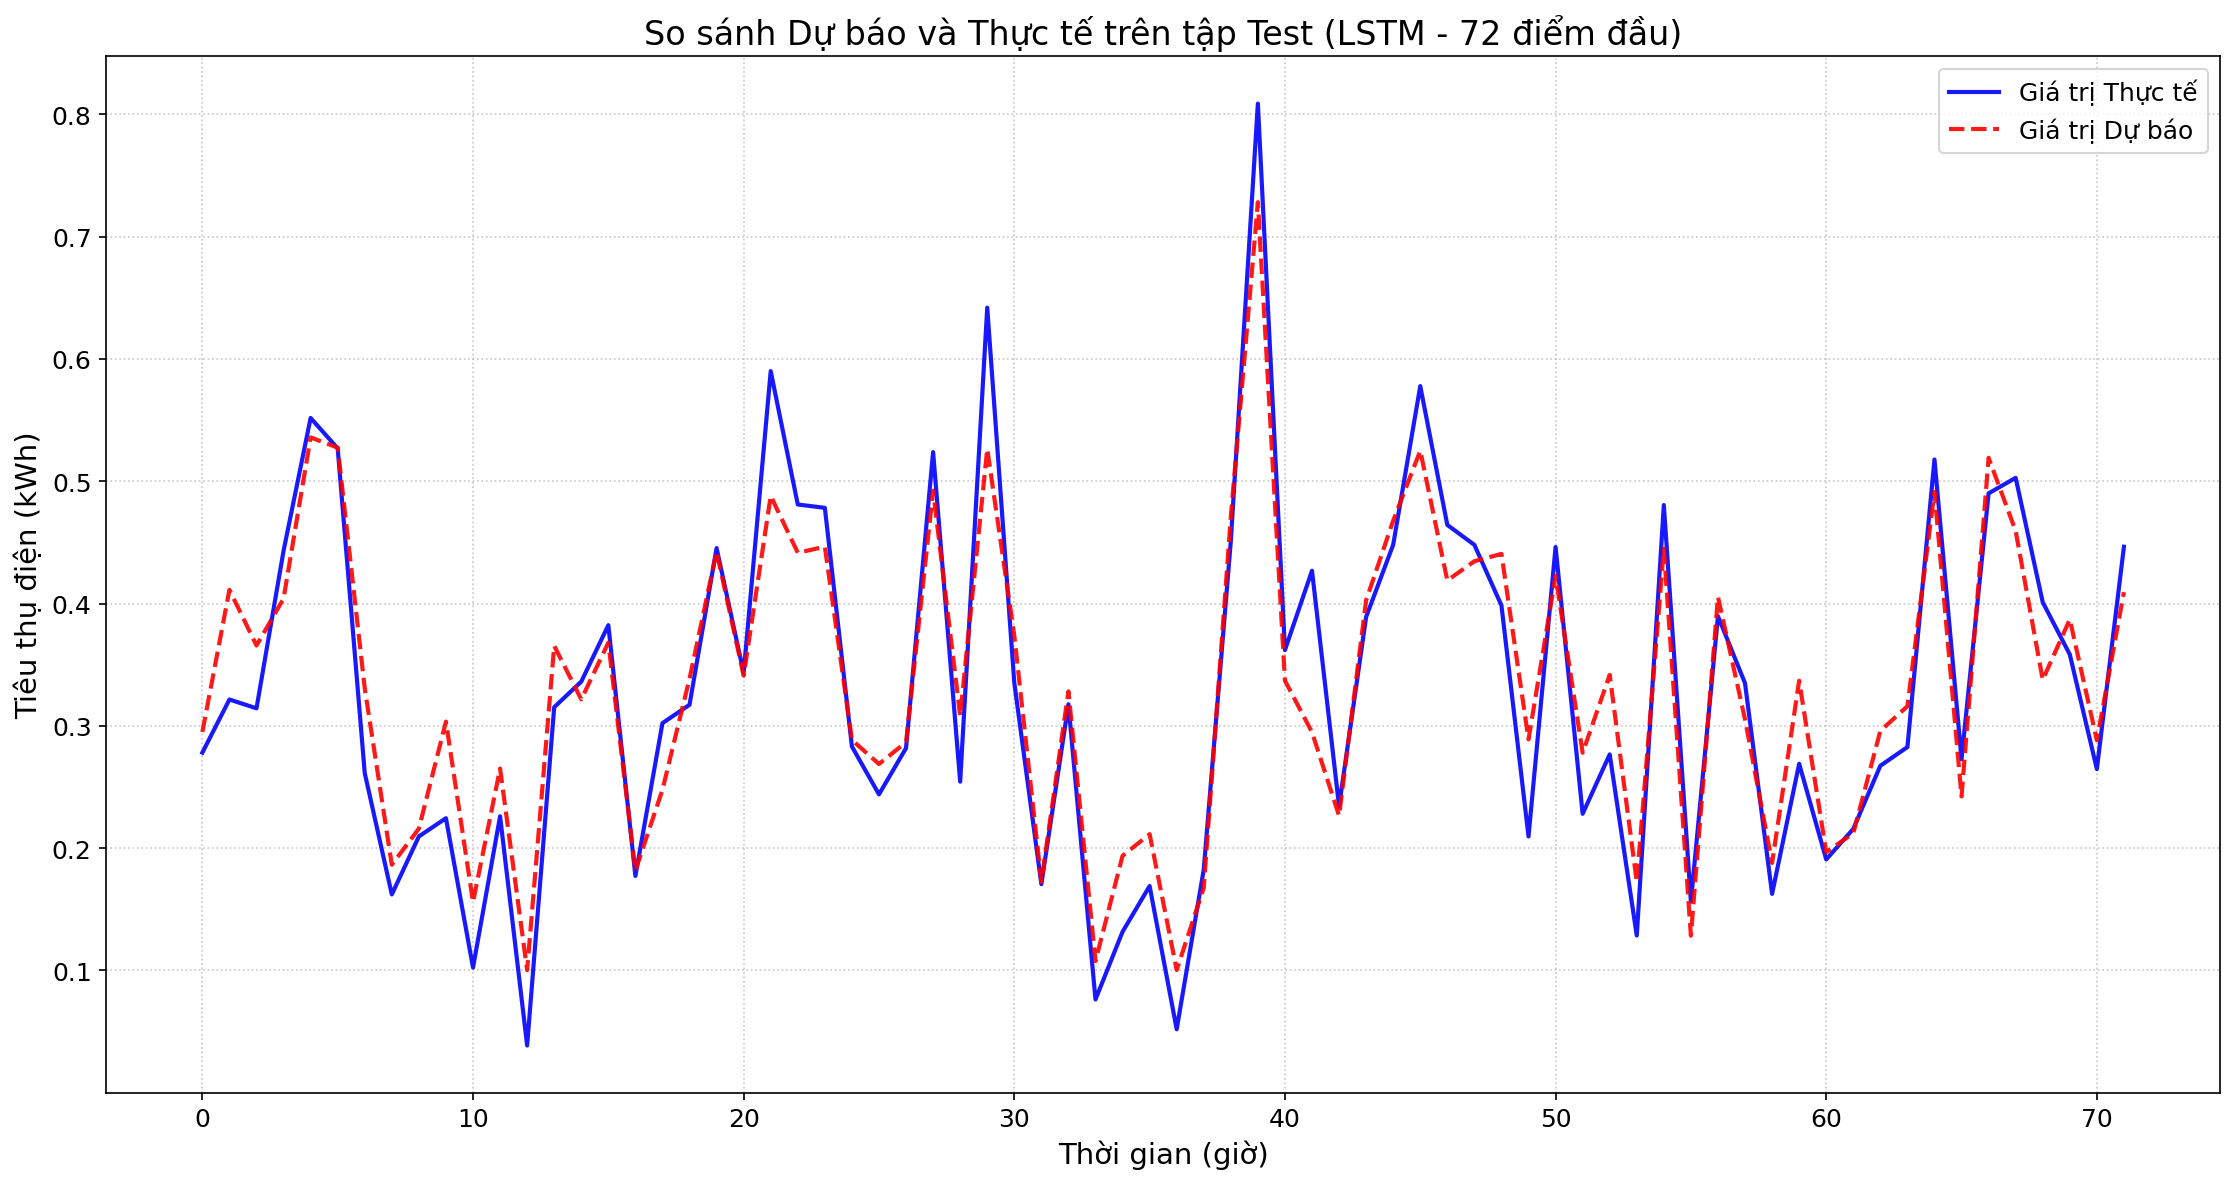

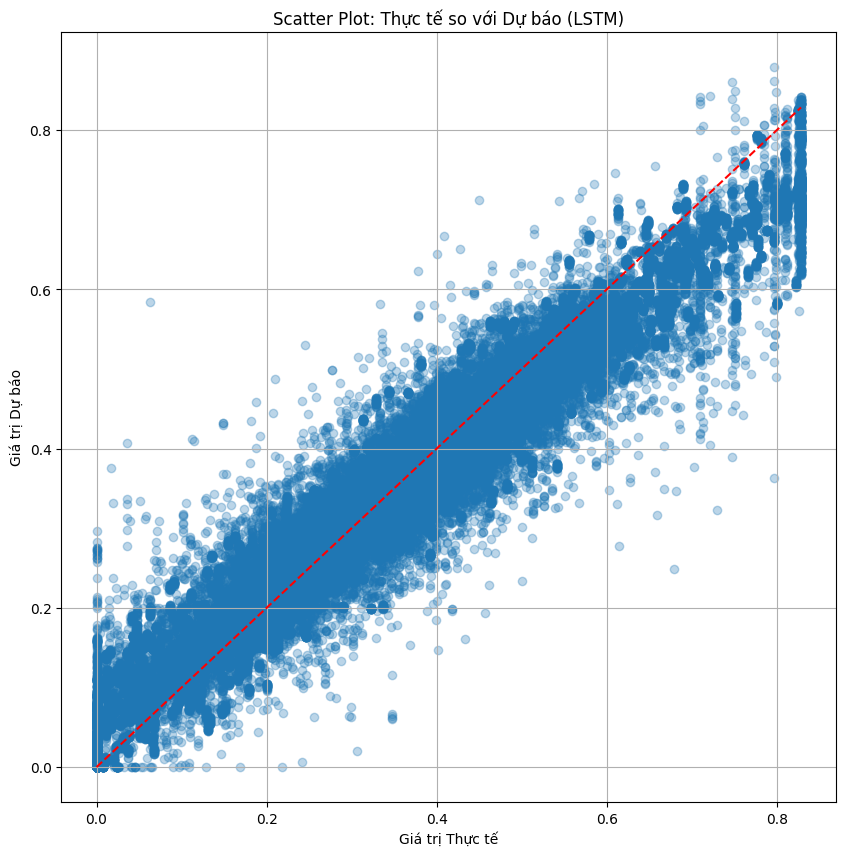


Tổng thời gian chạy toàn bộ pipeline (LSTM): 236.73 giây


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # Không cần khi không huấn luyện
import gc
import joblib

print("--- Kiểm tra và cấu hình GPU ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động. Có thể GPU đã được khởi tạo.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")
print("------------------------------")


FILE_PATH = 'C:/CODE/Python/11gb_data.csv' 


TEMP_CHUNKS_DIR_COMMON = 'E:/tmp_sliding_chunks' 
SCALER_DIR_COMMON = 'E:/tmp_scalers' 


# Cập nhật đường dẫn checkpoint theo yêu cầu của bạn
LSTM_CHECKPOINT_FILE = 'best_model_weights_lstm.weights.h5' 
LSTM_CHECKPOINT_PATH = os.path.join(SCALER_DIR_COMMON, LSTM_CHECKPOINT_FILE)


os.makedirs(TEMP_CHUNKS_DIR_COMMON, exist_ok=True)
os.makedirs(SCALER_DIR_COMMON, exist_ok=True)

# --- CÁC HẰNG SỐ CỦA MÔ HÌNH VÀ DATA ---
WINDOW_SIZE = 48
HORIZON = 24
STRIDE = 6 # Có thể không dùng đến nếu chỉ tải và predict

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000


def read_and_resample_chunks(csv_path, chunk_size=100_000):
    all_resampled_data = []
    print(f"📦 Đang bắt đầu quá trình đọc và resample chunk từ file CSV '{csv_path}'...")
    
    custom_dtypes = {
        'Value': np.float32, 
    }
    
    try:
        chunks = pd.read_csv(
            csv_path, 
            parse_dates=['Timestamp'], 
            chunksize=chunk_size,
            low_memory=True,
            dtype=custom_dtypes 
        )
    except Exception as e:
        print(f"❌ Lỗi khi đọc file CSV: {e}")
        print("Gợi ý: Kiểm tra lại tên các cột trong 'custom_dtypes' có khớp với file CSV không.")
        print("Hoặc thử bỏ 'dtype=custom_dtypes' nếu bạn không chắc chắn, nhưng nó có thể dùng nhiều RAM hơn.")
        raise 

    for i, chunk in enumerate(chunks):
        if chunk.empty:
            print(f"Chunk {i} rỗng, bỏ qua.")
            continue
        print(f"⏳ Đang xử lý Chunk {i} ({len(chunk)} dòng)...")
        
        chunk = chunk.set_index('Timestamp').sort_index()

        chunk['hour_sin'] = np.sin(2 * np.pi * chunk.index.hour / 24)
        chunk['hour_cos'] = np.cos(2 * np.pi * chunk.index.hour / 24)
        chunk['dayofweek_sin'] = np.sin(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofweek_cos'] = np.cos(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofyear_sin'] = np.sin(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['dayofyear_cos'] = np.cos(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['is_weekend'] = (chunk.index.dayofweek >= 5).astype(int)

        if 'Anomaly_Label' in chunk.columns:
            chunk = chunk.drop(columns=['Anomaly_Label'])
        
        if 'Meter_ID' in chunk.columns:
            chunk = chunk.drop(columns=['Meter_ID'])
        if 'Meter_ID_Numeric' in chunk.columns:
            chunk = chunk.drop(columns=['Meter_ID_Numeric'])

        numeric_chunk = chunk.select_dtypes(include=[np.number])

        numeric_chunk = numeric_chunk.interpolate(method='time', limit_direction='both')
        resampled_chunk = numeric_chunk.resample('1h').mean()
        resampled_chunk = resampled_chunk.ffill().bfill()
        
        if resampled_chunk.isnull().any().any():
            print(f"Cảnh báo: Chunk {i} vẫn còn giá trị NaN sau khi resample. Đang điền bằng trung bình cột.")
            resampled_chunk = resampled_chunk.fillna(resampled_chunk.mean())

        target_column_name = resampled_chunk.columns[0]
        Q1 = resampled_chunk[target_column_name].quantile(0.01)
        Q99 = resampled_chunk[target_column_name].quantile(0.99)
        resampled_chunk[target_column_name] = np.clip(resampled_chunk[target_column_name], Q1, Q99)
        
        for lag in [1, 24, 24*7]:
            resampled_chunk[f'{target_column_name}_lag_{lag}h'] = resampled_chunk[target_column_name].shift(lag)

        resampled_chunk = resampled_chunk.dropna()

        if not resampled_chunk.empty:
            all_resampled_data.append(resampled_chunk)
        print(f"✅ Hoàn thành xử lý Chunk {i}.")
        gc.collect()

    if not all_resampled_data:
        raise ValueError("Không có dữ liệu hợp lệ nào sau khi xử lý tất cả các chunk.")

    full_resampled_df = pd.concat(all_resampled_data)
    print(f"✅ Đã tổng hợp tất cả dữ liệu resample. Tổng số dòng: {len(full_resampled_df)}")
    gc.collect()
    return full_resampled_df



def load_npz_dataset(filepaths, batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, shuffle=True):
    def _load_npz_data_and_create_dataset(filepath_tensor):
        filepath_str = filepath_tensor.numpy().decode('utf-8')
        data = np.load(filepath_str)
        X = data['X']
        y = data['y']
        return tf.data.Dataset.from_tensor_slices((X, y))

    files_ds = tf.data.Dataset.from_tensor_slices(filepaths)

    dataset = files_ds.interleave(
        lambda filepath: tf.py_function(
            func=_load_npz_data_and_create_dataset,
            inp=[filepath],
            Tout=tf.data.DatasetSpec(
                element_spec=(
                    tf.TensorSpec(shape=(WINDOW_SIZE, None), dtype=tf.float32), 
                    tf.TensorSpec(shape=(HORIZON,), dtype=tf.float32) 
                )
            )
        ),
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size) 
    
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# --- ĐỊNH NGHĨA MÔ HÌNH LSTM ---
def create_lstm_model(input_shape, output_seq_len, d_model, num_layers, dropout_rate=0.3):
    model = Sequential()
    
    if num_layers == 1:
        model.add(LSTM(d_model, input_shape=input_shape, kernel_regularizer=l2(1e-3)))
    else:
        model.add(LSTM(d_model, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(1e-3)))
    
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for i in range(num_layers - 1):
        if i == num_layers - 2:
            model.add(LSTM(d_model, kernel_regularizer=l2(1e-3)))
        else:
            model.add(LSTM(d_model, return_sequences=True, kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
            
    model.add(Dense(output_seq_len))
    
    return model

# --- KHỐI THỰC THI CHÍNH ---
if __name__ == '__main__':
    start_time_full_process = time.time()
    
    print("\n🧹 Đang cố gắng dọn dẹp bộ nhớ...")
    tf.keras.backend.clear_session() 
    gc.collect() 
    print("✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.")

    # Kiểm tra sự tồn tại của file NPZ và scaler ở THƯ MỤC CHUNG
    existing_npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz'))
    existing_scaler_files = glob.glob(os.path.join(SCALER_DIR_COMMON, '*.pkl'))

    # Nếu KHÔNG CÓ file NPZ HOẶC KHÔNG CÓ file scaler trong thư mục chung, thì báo lỗi và thoát
    if not existing_npz_files or not existing_scaler_files:
        print("\n❌ LỖI: Không tìm thấy các file NPZ HOẶC Scaler trong thư mục chung.")
        print(f"Vui lòng đảm bảo các file NPZ (`{TEMP_CHUNKS_DIR_COMMON}`) và scaler (`{SCALER_DIR_COMMON}`) đã được tạo từ bước tiền xử lý hoặc huấn luyện trước đó.")
        print("Chương trình sẽ thoát.")
        exit() # Thoát nếu không có dữ liệu cần thiết

    else: # Nếu có file NPZ và scaler, thì tải chúng
        print(f"\n✅ Đã tìm thấy các file .npz trong '{TEMP_CHUNKS_DIR_COMMON}' và scaler trong '{SCALER_DIR_COMMON}'. Đang tải...")
        try:
            # TẢI SCALER TỪ THƯ MỤC CHUNG
            target_scaler = joblib.load(os.path.join(SCALER_DIR_COMMON, 'target_scaler.pkl')) 
            feature_scaler = joblib.load(os.path.join(SCALER_DIR_COMMON, 'feature_scaler.pkl')) 
            print(f"✅ Đã tải các scaler từ '{SCALER_DIR_COMMON}'.")
        except Exception as e:
            print(f"❌ Lỗi khi tải scaler: {e}. Vui lòng kiểm tra '{SCALER_DIR_COMMON}' hoặc chạy lại tiền xử lý.")
            exit()

    # Sử dụng các file NPZ từ thư mục chung
    npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz')) 
    if not npz_files:
        print(f"❌ Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR_COMMON}'. Vui lòng kiểm tra đường dẫn hoặc chạy lại tiền xử lý.")
        exit()

    print(f"✅ Đã tìm thấy {len(npz_files)} file .npz. Đang tải dữ liệu...")
    
    # Để xác định num_features, chúng ta cần tải một mẫu từ NPZ
    sample_data = np.load(npz_files[0])
    sample_X_shape = sample_data['X'].shape
    num_features = sample_X_shape[-1] # Lấy số lượng đặc trưng từ dữ liệu
    del sample_data, sample_X_shape 
    print(f"📈 Số lượng đặc trưng (num_features) được tự động phát hiện: {num_features}")


    # Lấy tổng số mẫu để chia dataset (để xác định tập test)
    # Cần đếm tổng số mẫu để xác định kích thước tập test
    total_samples = 0
    for filepath in npz_files:
        data = np.load(filepath)
        total_samples += data['X'].shape[0]
        data.close()
    print(f"✅ Tổng số mẫu được tải (đếm từ file NPZ): {total_samples}")

    # Chia kích thước tập dữ liệu (cần thiết để skip đến phần test)
    train_size = int(0.6 * total_samples)
    val_size = int(0.2 * total_samples)
    test_size = total_samples - train_size - val_size # test_size sẽ là phần còn lại

    train_batches = train_size // BATCH_SIZE
    val_batches = val_size // BATCH_SIZE
    test_batches = test_size // BATCH_SIZE # Số lượng batch thực tế cho test

    # --- KHỞI TẠO MÔ HÌNH LSTM VÀ TẢI TRỌNG SỐ ---
    print("\n🚀 Đang khởi tạo mô hình LSTM với cấu trúc...")
    model = create_lstm_model(
        input_shape=(WINDOW_SIZE, num_features),
        output_seq_len=HORIZON,
        d_model=64, # Đảm bảo tham số này khớp với lúc huấn luyện
        num_layers=2, # Đảm bảo tham số này khớp với lúc huấn luyện
        dropout_rate=0.3 # Đảm bảo tham số này khớp với lúc huấn luyện
    )
    
    # Cần compile mô hình trước khi load_weights nếu mô hình chưa từng được huấn luyện
    # Hoặc nếu bạn muốn tiếp tục sử dụng các optimizer/loss từ quá trình huấn luyện trước
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Learning rate không quan trọng nếu chỉ load và predict
        loss=tf.keras.losses.Huber(), 
        metrics=['mae']
    )
    model.summary() 
    print("✅ Đã khởi tạo mô hình LSTM với cấu trúc.")

    # TẢI TRỌNG SỐ TỪ ĐƯỜNG DẪN MỚI
    try:
        print(f"\n⏳ Đang tải trọng số tốt nhất cho LSTM từ '{LSTM_CHECKPOINT_PATH}'...")
        if not os.path.exists(LSTM_CHECKPOINT_PATH):
            raise FileNotFoundError(f"File trọng số không tồn tại: {LSTM_CHECKPOINT_PATH}")
        model.load_weights(LSTM_CHECKPOINT_PATH) 
        print(f"✅ Đã tải trọng số tốt nhất cho LSTM từ '{LSTM_CHECKPOINT_PATH}'")
    except Exception as e:
        print(f"❌ Lỗi khi tải trọng số tốt nhất cho LSTM: {e}")
        print("Chương trình sẽ thoát vì không thể tải trọng số cần thiết để dự đoán.")
        exit() 

  

    print("\n📈 Đang dự báo trên tập test (LSTM)...")
    start_test = time.time()
    
    y_true_list = []
    y_pred_list = []

    # Quan trọng: Tạo lại test_dataset mà không shuffle để giữ thứ tự thời gian
    full_dataset_for_prediction = load_npz_dataset(npz_files, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=False) # RẤT QUAN TRỌNG: KHÔNG SHUFFLE TẬP TEST ĐỂ GIỮ THỨ TỰ THỜI GIAN

    # Bỏ qua các mẫu train và validation để chỉ lấy mẫu test theo thứ tự
    test_dataset_for_prediction = full_dataset_for_prediction.skip(train_batches + val_batches)


    for X_batch, y_batch in test_dataset_for_prediction: 
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_true_list.append(y_batch.numpy())
        y_pred_list.append(y_pred_batch)

    y_true_all_scaled = np.concatenate(y_true_list, axis=0)
    y_pred_all_scaled = np.concatenate(y_pred_list, axis=0)

    print(f"✅ Dự báo hoàn tất sau {time.time() - start_test:.2f} giây")

    # Lấy giá trị dự báo và thực tế cho bước đầu tiên (điểm dự báo đầu tiên)
    true_scaled_first_step = y_true_all_scaled[:, 0].reshape(-1, 1)
    predicted_scaled_first_step = y_pred_all_scaled[:, 0].reshape(-1, 1)

    # Đảm bảo bạn tải đúng scaler để đảo ngược chuẩn hóa
    true = target_scaler.inverse_transform(true_scaled_first_step).flatten()
    predicted = target_scaler.inverse_transform(predicted_scaled_first_step).flatten()

    predicted[predicted < 0] = 0
    true[true < 0] = 0

    print("✅ Đã tạo biến 'true' và 'predicted' thành công và sẵn sàng để vẽ.")

    def smape(y_true, y_pred):
        numerator = np.abs(y_pred - y_true)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-8
        return 100 * np.mean(numerator / denominator)

    print("\n📊 Evaluation on Test Set (LSTM):")
    print(f"MAE  = {mean_absolute_error(true, predicted):.4f}")
    print(f"MSE  = {mean_squared_error(true, predicted):.4f}")
    print(f"RMSE = {np.sqrt(mean_squared_error(true, predicted)):.4f}")

    epsilon = 1e-8
    mape = np.mean(np.abs((true - predicted) / (true + epsilon))) * 100
    print(f"MAPE = {mape:.2f}%")
    print(f"sMAPE= {smape(true, predicted):.2f}%")

  

    # Biểu đồ 1: So sánh Dự báo và Thực tế trên tập Test (Chi tiết - 72 điểm đầu)
    if 'true' in locals() and 'predicted' in locals():
        plt.figure(figsize=(15, 8), dpi=150) # Tăng DPI để ảnh nét hơn khi phóng to
        
        sample_size_for_detail = 72 # 72 điểm = 3 ngày x 24 giờ/ngày
        
        # Đảm bảo lấy đủ số lượng mẫu, nếu không có đủ thì lấy tất cả
        plot_true_detail = true[:sample_size_for_detail] if len(true) >= sample_size_for_detail else true
        plot_predicted_detail = predicted[:sample_size_for_detail] if len(predicted) >= sample_size_for_detail else predicted

        plt.plot(plot_true_detail, label='Giá trị Thực tế', alpha=0.9, linewidth=2, color='blue') # Tăng linewidth, thêm màu
        plt.plot(plot_predicted_detail, label='Giá trị Dự báo', alpha=0.9, linestyle='--', linewidth=2, color='red') # Tăng linewidth, thêm màu
        plt.legend(loc='upper right', fontsize=12) # Đặt legend ở góc trên bên phải
        plt.title(f'So sánh Dự báo và Thực tế trên tập Test (LSTM - {len(plot_true_detail)} điểm đầu)', fontsize=16)
        plt.xlabel('Thời gian (giờ)', fontsize=14)
        plt.ylabel('Tiêu thụ điện (kWh)', fontsize=14)
        plt.grid(True, linestyle=':', alpha=0.7) # Thêm kiểu lưới
        plt.xticks(fontsize=12) # Kích thước font cho trục x
        plt.yticks(fontsize=12) # Kích thước font cho trục y
        plt.tight_layout()
        plt.show()
    else:
        print("Không thể vẽ biểu đồ So sánh Dự báo và Thực tế: Biến 'true' hoặc 'predicted' không tồn tại.")

    # Biểu đồ 2: Scatter Plot: Thực tế so với Dự báo 
    if 'true' in locals() and 'predicted' in locals():
        plt.figure(figsize=(10, 10))
        plt.scatter(true, predicted, alpha=0.3)
        plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
        plt.xlabel('Giá trị Thực tế')
        plt.ylabel('Giá trị Dự báo')
        plt.title('Scatter Plot: Thực tế so với Dự báo (LSTM)') 
        plt.grid(True)
        plt.show()
    else:
        print("Không thể vẽ biểu đồ Scatter Plot: Biến 'true' hoặc 'predicted' không tồn tại.")

    print(f"\nTổng thời gian chạy toàn bộ pipeline (LSTM): {time.time() - start_time_full_process:.2f} giây")